## 1. Start a *SAS* session & work with it 
#### 1.1 Show connection details
The connection we choose here is communicating via ssh, see [SASPy Configuration](https://sassoftware.github.io/saspy/configuration.html) for details.

In [0]:
%sh awk '/^ssh_sas/,/}/' /databricks/sasconfig/sascfg_personal.py

ssh_sas = {'saspath' : '/opt/sas/sashome/SASFoundation/9.4/bin/sas_u8',
 'ssh' : '/usr/bin/ssh',
 'host' : '***.**.*.*',
 'luser' : 'sas',
 'identity': '/databricks/sasconfig/id_rsa_sas_dbr',
 'tunnel' : 9911,
 'rtunnel' : 9912,
 'options' : ["-fullstimer"]
 }

####1.2 Start the SAS session
*SAS* code is submitted from Python through the [*SASPy*](https://sassoftware.github.io/saspy/) module using the `SASsession` object `sas` which is instantiated below.

In [0]:
import saspy
# Start a SAS Session using config file
sas = saspy.SASsession(
  cfgfile = '/databricks/sasconfig/sascfg_personal.py',
  cfgname = 'ssh_sas',
  display = 'databricks')
# Redefine `sas.DISPLAY`
def dbDISPLAY(x):
  displayHTML(x)
sas.DISPLAY = dbDISPLAY


SAS Connection established. Subprocess id is 5038

Note, we redefined the *SASPy* function `dbDISPLAY` as we experienced issues with the scope of the original definition - see below where it's located.

In [0]:
%sh awk '/dbDISPLAY|displayHTML/ {print NR, $0}' /databricks/python3/lib/python3.8/site-packages/saspy/sasbase.py

90 def dbDISPLAY(x):
91 displayHTML(x)
216 self.DISPLAY = dbDISPLAY

####1.3 Submit SAS code
The `submitLST` method sends a string of *SAS* code to the *SAS* session and returns the result delivered from the [SAS Output Delivery System (ODS)](https://documentation.sas.com/doc/en/dispatch/9.4/ods.htm). Here we show the content of the [Class Data](https://documentation.sas.com/doc/en/pgmsascdc/9.4_3.5/statug/statug_sashelp_sect009.htm)  `sashelp.class`.

In [0]:
sas.submitLST("PROC PRINT DATA=sashelp.class; RUN;")

Obs,Name,Sex,Age,Height,Weight
1,Alfred,M,14,69.0,112.5
2,Alice,F,13,56.5,84.0
3,Barbara,F,13,65.3,98.0
4,Carol,F,14,62.8,102.5
5,Henry,M,14,63.5,102.5
6,James,M,12,57.3,83.0
7,Jane,F,12,59.8,84.5
8,Janet,F,15,62.5,112.5
9,Jeffrey,M,13,62.5,84.0
10,John,M,12,59.0,99.5


*SASPy* contains convenience functions, which already generate the necessary *SAS* code under the hood - e.g. `describe` and `hist` below are called on the [SAS data object](https://sassoftware.github.io/saspy/api.html#sas-data-object).

Variable N NMiss Median Mean ... Min P25 P50 P75 Max
0 Age 19.0 0.0 13.0 13.315789 ... 11.0 12.0 13.0 15.0 16.0
1 Height 19.0 0.0 62.8 62.336842 ... 51.3 57.5 62.8 66.5 72.0
2 Weight 19.0 0.0 99.5 100.026316 ... 50.5 84.0 99.5 112.5 150.0

[3 rows x 11 columns]

<!DOCTYPE html>
 
 
 
 
 SAS Output
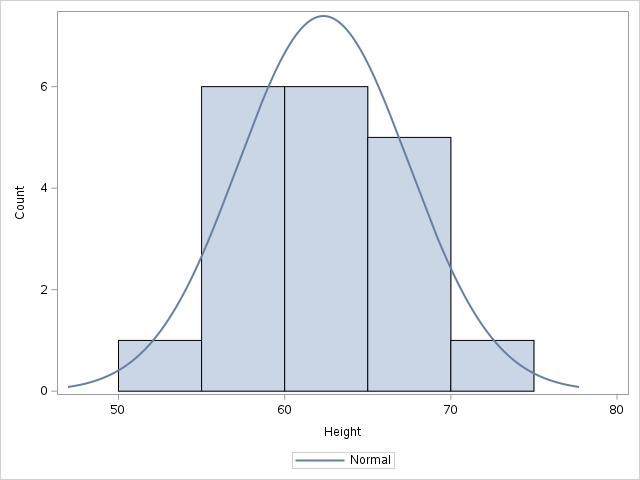

In [0]:
cs = sas.sasdata('class', 'sashelp')
print(cs.describe())
cs.hist('Height')

The generated *SAS* code can be inspected with the `teach_me_SAS` method of the *SAS* session object.

In [0]:
sas.teach_me_SAS(1)
print(cs.describe())
cs.hist('Height')
sas.teach_me_SAS(0)

proc means data=sashelp.'class'n stackodsoutput n nmiss median mean std min p25 p50 p75 max;run;
None
proc sgplot data=sashelp.'class'n ;
	histogram 'Height'n / scale=count;
	density 'Height'n;
run;
title;

####1.4 Write data to the Databricks spark cluster.

For this we create the database `sas_dbr_demo` - unless it exists - and potentially drop the `class` table from it...

In [0]:
%sql
CREATE DATABASE IF NOT EXISTS sas_dbr_demo;
DROP TABLE IF EXISTS sas_dbr_demo.class;

...then we connect *SAS* to this database - here via *JDBC* - by creating the `sdd` library. Note, that `submitLST` will return the *SAS* log if no output for *ODS* is created. Note, that we store both server `SRV`and password `PWD` in a *Widget*, which we have to `get` first.

In [0]:
dbutils.widgets.text("PWD","")
PWD = dbutils.widgets.get("PWD")
dbutils.widgets.text("SRV","")
SRV = dbutils.widgets.get("SRV")

In [0]:
sas.submitLST(f"""
option set=SAS_ACCESS_CLASSPATH="/opt/sas/drivers";
libname sdd jdbc driverclass="com.simba.spark.jdbc.Driver"
url="jdbc:spark://{SRV}:443/default;transportMode=http;
ssl=1;httpPath=sql/protocolv1/o/6447497411580861/1019-182657-tjwinew;AuthMech=3;
UID=token;PWD={PWD}"  readbuff=10000 schema="sas_dbr_demo";
""")

160 ods listing close;ods html5 (id=saspy_internal) file=stdout options(bitmap_mode='inline') device=svg style=HTMLBlue; ods
160! graphics on / outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: STDOUT
161 
162 
163 option set=SAS_ACCESS_CLASSPATH="/opt/sas/drivers";
164 libname sdd jdbc driverclass="com.simba.spark.jdbc.Driver"
165 url="jdbc:spark://***-****************.1.azuredatabricks.net:443/default;transportMode=http;
166 ssl=1;httpPath=sql/protocolv1/o/6447497411580861/1019-182657-tjwinew;AuthMech=3;
167 UID=token;PWD=************************************-*" readbuff=10000 schema="sas_dbr_demo";
NOTE: Libref SDD was successfully assigned as follows: 
 Engine: JDBC 
 Physical Name: 
 jdbc:spark://***-****************.1.azuredatabricks.net:443/sas_dbr_demo;transportMode=http;ssl=1;httpPath=sql/protocolv1/o/64
 47497411580861/1019-182657-tjwinew;AuthMech=3;UID=token;PWD=************************************-*
168 
169 
170 ods html5 (id=saspy_internal) close;ods listing;

Eventually, we create the table `class` in the database `sas_dbr_demo` using library `sdd`, show it's contents ...

In [0]:
sas.submitLST("""
DATA sdd.class; SET sashelp.class; RUN;
PROC CONTENTS DATA=sdd.class; RUN;
""")

<!DOCTYPE html>
 
 
 
 
 SAS Output 

 
 
 
 
 The CONTENTS Procedure 
 
 
 
 
 
 
 
 
 Data Set Name 
 SDD.CLASS 
 Observations 
 . 
 
 
 Member Type 
 DATA 
 Variables 
 5 
 
 
 Engine 
 JDBC 
 Indexes 
 0 
 
 
 Created 
 . 
 Observation Length 
 0 
 
 
 Last Modified 
 . 
 Deleted Observations 
 0 
 
 
 Protection 
   
 Compressed 
 NO 
 
 
 Data Set Type 
   
 Sorted 
 NO 
 
 
 Label 
   
   
   
 
 
 Data Representation 
 Default 
   
   
 
 
 Encoding 
 Default 
   
   
 
 
 
 
 
 
 
 
 
 
 Alphabetic List of Variables and Attributes 
 
 
 # 
 Variable 
 Type 
 Len 
 Format 
 Informat 
 Label 
 
 
 
 
 3 
 Age 
 Num 
 8 
   
   
 Age 
 
 
 4 
 Height 
 Num 
 8 
   
   
 Height 
 
 
 1 
 Name 
 Char 
 765 
 $765. 
 $765. 
 Name 
 
 
 2 
 Sex 
 Char 
 765 
 $765. 
 $765. 
 Sex 
 
 
 5 
 Weight 
 Num 
 8 
   
   
 Weight

... and show it via Databricks' *SQL*. The result can be shown as a plot, e.g. resembling the histogram generated with *SAS* above

In [0]:
%sql
SELECT * FROM sas_dbr_demo.class;

Name,Sex,Age,Height,Weight
Henry,M,14.0,63.5,102.5
James,M,12.0,57.3,83.0
Jane,F,12.0,59.8,84.5
Janet,F,15.0,62.5,112.5
Jeffrey,M,13.0,62.5,84.0
Philip,M,16.0,72.0,150.0
Robert,M,12.0,64.8,128.0
Ronald,M,15.0,67.0,133.0
Thomas,M,11.0,57.5,85.0
William,M,15.0,66.5,112.0


Note that `class` is automatically stored as a Delta table of type `MANAGED`:

In [0]:
%sql
DESCRIBE EXTENDED sas_dbr_demo.class;

col_name,data_type,comment
Name,varchar(8),
Sex,varchar(1),
Age,double,
Height,double,
Weight,double,
,,
# Partitioning,,
Not partitioned,,
,,
# Detailed Table Information,,


####1.5 Directly transfer `class` to a Pandas data frame `cp`

by calling the `to_df()` method on `cs` - the Python variable representing the `sashelp.class` *SAS* data set ...

In [0]:
import pandas as pd
cp = cs.to_df()
display(cp)

Name,Sex,Age,Height,Weight
Alfred,M,14.0,69.0,112.5
Alice,F,13.0,56.5,84.0
Barbara,F,13.0,65.3,98.0
Carol,F,14.0,62.8,102.5
Henry,M,14.0,63.5,102.5
James,M,12.0,57.3,83.0
Jane,F,12.0,59.8,84.5
Janet,F,15.0,62.5,112.5
Jeffrey,M,13.0,62.5,84.0
John,M,12.0,59.0,99.5


Now we can use the whole stack of python libraries for analyzing the `cp` data frame - e.g. creating a [linear model plot with *Seaborn*](https://seaborn.pydata.org/generated/seaborn.lmplot.html)

Out[11]:

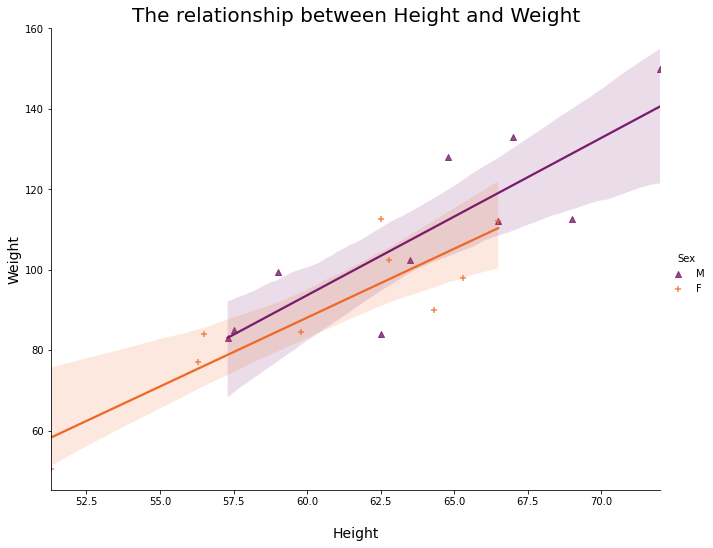

Text(0.5, 1.0, 'The relationship between Height and Weight')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(data=cp,
           x='Height',
           y='Weight',
           hue='Sex',
           markers=['^', '+'],
           palette='inferno',
           height=7,
           aspect=1.3)
plt.xlabel('Height', fontsize=14, labelpad=20)
plt.ylabel('Weight', fontsize=14)
plt.title('The relationship between Height and Weight', fontsize=20)

Let's store the table once more - this time as `class_p` - taking it from the Pandas data frame `cp`.

In [0]:
# https://docs.microsoft.com/en-us/azure/databricks/spark/latest/spark-sql/spark-pandas
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.get("spark.sql.execution.arrow.fallback.enabled") # Should be "true"

st = spark.sql(f"show tables from sas_dbr_demo")
if st[st.tableName=='class_p'].count() < 1:
  save_path = '/FileStore/tables/sas_dbr_demo/class_p'
  spark.createDataFrame(cp).write.format('delta').save(save_path)
  spark.sql("CREATE TABLE sas_dbr_demo.class_p USING DELTA LOCATION '" + save_path + "'")

This time we explicitely gave a save location, resulting in type `EXTERNAL`.

In [0]:
%sql
DESCRIBE EXTENDED sas_dbr_demo.class_p;

col_name,data_type,comment
Name,string,
Sex,string,
Age,double,
Height,double,
Weight,double,
,,
# Partitioning,,
Not partitioned,,
,,
# Detailed Table Information,,


##2. Work in *R*
####2.1 Use the Class Data
First we create a Spark data frame `cs` from Delta table `sas_dbr_demo.class` aka `sashelp.class`...

In [0]:
%r
library(SparkR)
sparkR.session()
cs = tableToDF("sas_dbr_demo.class")
display(cs)

Name,Sex,Age,Height,Weight
Henry,M,14.0,63.5,102.5
James,M,12.0,57.3,83.0
Jane,F,12.0,59.8,84.5
Janet,F,15.0,62.5,112.5
Jeffrey,M,13.0,62.5,84.0
Philip,M,16.0,72.0,150.0
Robert,M,12.0,64.8,128.0
Ronald,M,15.0,67.0,133.0
Thomas,M,11.0,57.5,85.0
William,M,15.0,66.5,112.0


Attaching package: ‘SparkR’

The following object is masked _by_ ‘.GlobalEnv’:

 setLocalProperty

The following objects are masked from ‘package:stats’:

 cov, filter, lag, na.omit, predict, sd, var, window

The following objects are masked from ‘package:base’:

 as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
 rank, rbind, sample, startsWith, subset, summary, transform, union

... then we fit the linear model `cm` for `Weight` based on `Height` and `Sex`.
Note, `lm` expects an *R* data frame; therefore we use `collect`
on the *SparkDataFrame* `cs` to convert it to an *R* data frame.

In [0]:
%r
print(cs)
cm <- lm(Weight~Height + Sex, data=collect(cs))
summary(cm)

SparkDataFrame[Name:string, Sex:string, Age:double, Height:double, Weight:double]

Call:
lm(formula = Weight ~ Height + Sex, data = collect(cs))

Residuals:
 Min 1Q Median 3Q Max 
-19.7627 -5.9583 -0.3682 8.7725 15.7758 

Coefficients:
 Estimate Std. Error t value Pr(>|t|) 
(Intercept) -132.7895 32.8749 -4.039 0.00095 ***
Height 3.6789 0.5392 6.823 4.09e-06 ***
SexM 6.6208 5.3887 1.229 0.23697 
---
Signif. codes: 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.06 on 16 degrees of freedom
Multiple R-squared: 0.7903,	Adjusted R-squared: 0.7641 
F-statistic: 30.15 on 2 and 16 DF, p-value: 3.74e-06

####2.2 Use *R*'s `mtcars` data set

Create and display *Spark* data frame `mtc` from `mtcars`, and additionally show the help entry for `mtcars`.

In [0]:
%r
mtc = createDataFrame(mtcars)
display(mtc)
help(mtcars)

mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
21.0,6.0,160.0,110.0,3.9,2.62,16.46,0.0,1.0,4.0,4.0
21.0,6.0,160.0,110.0,3.9,2.875,17.02,0.0,1.0,4.0,4.0
22.8,4.0,108.0,93.0,3.85,2.32,18.61,1.0,1.0,4.0,1.0
21.4,6.0,258.0,110.0,3.08,3.215,19.44,1.0,0.0,3.0,1.0
18.7,8.0,360.0,175.0,3.15,3.44,17.02,0.0,0.0,3.0,2.0
18.1,6.0,225.0,105.0,2.76,3.46,20.22,1.0,0.0,3.0,1.0
14.3,8.0,360.0,245.0,3.21,3.57,15.84,0.0,0.0,3.0,4.0
24.4,4.0,146.7,62.0,3.69,3.19,20.0,1.0,0.0,4.0,2.0
22.8,4.0,140.8,95.0,3.92,3.15,22.9,1.0,0.0,4.0,2.0
19.2,6.0,167.6,123.0,3.92,3.44,18.3,1.0,0.0,4.0,4.0


mtcars package:datasets R Documentation

Motor Trend Car Road Tests

Description:

 The data was extracted from the 1974 _Motor Trend_ US magazine,
 and comprises fuel consumption and 10 aspects of automobile design
 and performance for 32 automobiles (1973-74 models).

Usage:

 mtcars
 
Format:

 A data frame with 32 observations on 11 (numeric) variables.

 [, 1] mpg Miles/(US) gallon 
 [, 2] cyl Number of cylinders 
 [, 3] disp Displacement (cu.in.) 
 [, 4] hp Gross horsepower 
 [, 5] drat Rear axle ratio 
 [, 6] wt Weight (1000 lbs) 
 [, 7] qsec 1/4 mile time 
 [, 8] vs Engine (0 = V-shaped, 1 = straight) 
 [, 9] am Transmission (0 = automatic, 1 = manual) 
 [,10] gear Number of forward gears 
 [,11] carb Number of carburetors 
 
Note:

 Henderson and Velleman (1981) comment in a footnote to Table 1:
 ‘Hocking [original transcriber]'s noncrucial coding of the Mazda's
 rotary engine as a straight six-cylinder engine and the Porsche's
 flat engine as a V engine, as well as the inclusion of the diesel
 Mercedes 240D, have been retained to enable direct comparisons to
 be made with previous analyses.’

Source:

 Henderson and Velleman (1981), Building multiple regression models
 interactively. _Biometrics_, *37*, 391-411.

Examples:

 require(graphics)
 pairs(mtcars, main = "mtcars data", gap = 1/4)
 coplot(mpg ~ disp | as.factor(cyl), data = mtcars,
 panel = panel.smooth, rows = 1)
 ## possibly more meaningful, e.g., for summary() or bivariate plots:
 mtcars2 <- within(mtcars, {
 vs <- factor(vs, labels = c("V", "S"))
 am <- factor(am, labels = c("automatic", "manual"))
 cyl <- ordered(cyl)
 gear <- ordered(gear)
 carb <- ordered(carb)
 })
 summary(mtcars2)

####2.3 Fit linear model for `mtcars`

This time we first split the data frame into training sample `mtc_trn` and test sample `mtc_tst`, fit the linear model `mtc_mod` on the training data and show the model summary.

In [0]:
%r
data(mtcars)
set.seed(42)                                              # setting seed to reproduce results of random sampling
mtc_rix <- base::sample(1:nrow(mtcars), 0.7*nrow(mtcars)) # row indices for 70% training sample
mtc_trn <- mtcars[mtc_rix, ]                              # model training data
mtc_tst <- mtcars[-mtc_rix, ]                             # test data
mtc_mod <- lm(mpg ~ wt+hp+am, data=mtc_trn)               # build the model
summary(mtc_mod)

Call:
lm(formula = mpg ~ wt + hp + am, data = mtc_trn)

Residuals:
 Min 1Q Median 3Q Max 
-2.943 -1.457 -0.277 1.116 5.962 

Coefficients:
 Estimate Std. Error t value Pr(>|t|) 
(Intercept) 31.47347 2.75413 11.428 1.1e-09 ***
wt -2.29545 0.92365 -2.485 0.02301 * 
hp -0.03479 0.01060 -3.283 0.00414 ** 
am 2.31007 1.45682 1.586 0.13022 
---
Signif. codes: 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.355 on 18 degrees of freedom
Multiple R-squared: 0.839,	Adjusted R-squared: 0.8122 
F-statistic: 31.27 on 3 and 18 DF, p-value: 2.366e-07

With `mtc_pred`, the predictions on the test data, we then calculate R squared of the test data and the residuals of actual against predicted values.

In [0]:
%r
mtc_prd <- predict(mtc_mod, mtc_tst)                       # predict miles/gallon
act_prd <- data.frame(cbind(act=mtc_tst$mpg, prd=mtc_prd)) # data frame actuals vs predictions
print( cor(act_prd)^2 )                                    # r.squared of test data
act_prd$rsd <- act_prd$act - act_prd$prd                   # add residuals
display(act_prd)

act,prd,rsd
21.0,23.357485489114822,-2.357485489114822
18.1,19.878512297606278,-1.7785122976062766
24.4,21.994149174041606,2.4058508259583924
17.3,16.649673675480496,0.6503263245195043
30.4,28.26743312960978,2.1325668703902174
33.9,27.310195488030317,6.589804511969682
15.2,18.37045864186462,-3.17045864186462
30.4,26.379528402360346,4.020471597639652
15.8,17.32304375818021,-1.5230437581802079
19.7,21.33731689955035,-1.637316899550349


act prd
act 1.0000000 0.8833932
prd 0.8833932 1.0000000

Eventually we store the `mtc_(all|trn|tst)` data frames in database `sas_dbr_demo` using the same name, respectively.

In [0]:
%r
st = sql(paste("show tables from sas_dbr_demo"))
if ( count(filter(st, st$tableName=='mtc_all')) < 1 ) {
  save_path = '/FileStore/tables/sas_dbr_demo/mtc/all'
  write.df(mtc, source = 'delta', path = save_path)
  sql(paste("CREATE TABLE sas_dbr_demo.mtc_all USING DELTA LOCATION '", save_path, "'", sep = ""))
}
if ( count(filter(st, st$tableName=='mtc_trn')) < 1 ) {
  save_path = "/FileStore/tables/sas_dbr_demo/mtc/trn"
  write.df(createDataFrame(mtc_trn), source="delta", path=save_path)
  sql(paste("CREATE TABLE sas_dbr_demo.mtc_trn USING DELTA LOCATION '", save_path, "'", sep = ""))
}
if ( count(filter(st, st$tableName=='mtc_tst')) < 1 ) {
  save_path = "/FileStore/tables/sas_dbr_demo/mtc/tst"
  write.df(createDataFrame(mtc_tst), source="delta", path=save_path)
  sql(paste("CREATE TABLE sas_dbr_demo.mtc_tst USING DELTA LOCATION '", save_path, "'", sep = ""))
}


SparkDataFrame[]

## 3. Analysis of `mtcars` in SAS
####3.1 Visualize `mpg` against `cyl`
using the `heatmap` method

""
32


<!DOCTYPE html>
 
 
 
 
 SAS Output
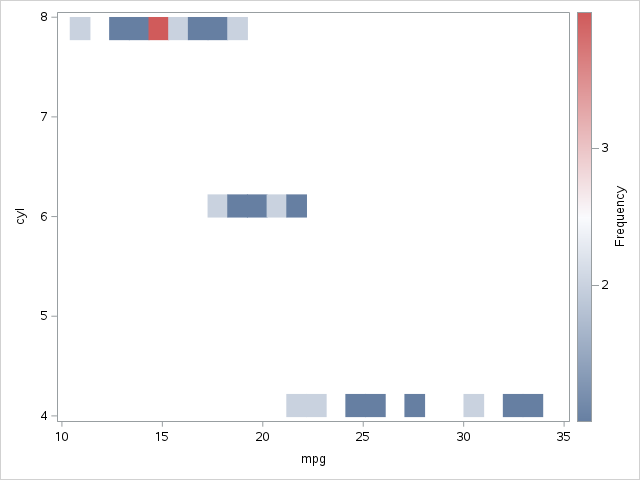

In [0]:
sas.submitLST('''
proc sql; 
  create table mtc as select * from sdd.mtc_all;
  select count(*) from mtc;
quit;
''')
mtc = sas.sasdata('mtc', 'work')
mtc.heatmap('mpg', 'cyl')

####3.2 Create a linear model
resembling the *R* regression model from **2.3** with `proc reg` and storing the score code in `mtc_prd.sas` in the *SAS* work folder.

<!DOCTYPE html>
 
 
 
 
 SAS Output 

 
 
 
 
 The REG Procedure 
 Model: MODEL1 
 Dependent Variable: mpg mpg 
 
 
 
 
 
 
 
 
 
 
 Number of Observations Read 
 22 
 
 
 Number of Observations Used 
 22 
 
 
 
 
 
 
 
 
 
 
 Analysis of Variance 
 
 
 Source 
 DF 
 Sum of Squares 
 Mean Square 
 F Value 
 Pr > F 
 
 
 
 
 Model 
 3 
 520.25413 
 173.41804 
 31.27 
 <.0001 
 
 
 Error 
 18 
 99.81905 
 5.54550 
   
   
 
 
 Corrected Total 
 21 
 620.07318 
   
   
   
 
 
 
 
 
 
 
 
 
 
 Root MSE 
 2.35489 
 R-Square 
 0.8390 
 
 
 Dependent Mean 
 18.94091 
 Adj R-Sq 
 0.8122 
 
 
 Coeff Var 
 12.43282 
   
   
 
 
 
 
 
 
 
 
 
 
 Parameter Estimates 
 
 
 Variable 
 Label 
 DF 
 Parameter Estimate 
 Standard Error 
 t Value 
 Pr > |t| 
 
 
 
 
 Intercept 
 Intercept 
 1 
 31.47347 
 2.75413 
 11.43 
 <.0001 
 
 
 wt 
 wt 
 1 
 -2.29545 
 0.92365 
 -2.49 
 0.0230 
 
 
 hp 
 hp 
 1 
 -0.03479 
 0.01060 
 -3.28 
 0.0041 
 
 
 am 
 am 
 1 
 2.31007 
 1.45682 
 1.59 
 0.1302 
 
 
 
 
 
 
 
 
 The REG Procedure 
 Model: MODEL1 
 Dependent Variable: mpg mpg
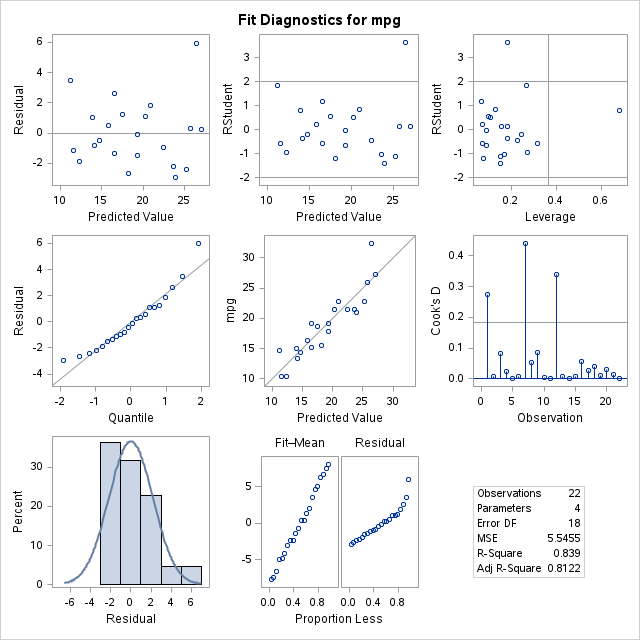
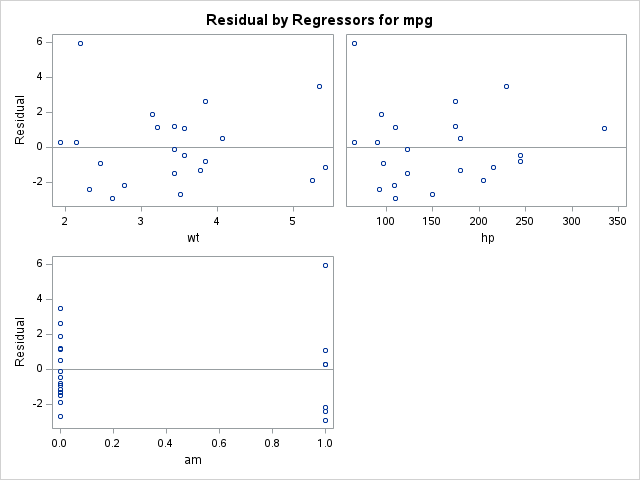

In [0]:
sas.submitLST('''
proc reg data=sdd.mtc_trn outest=mtc_est tableout;
  model mpg = wt hp am;
  code file="%sysfunc(GETOPTION(WORK))/mtc_prd.sas";
run;
''')

####3.3 Score the test sample `mtc_tst`
using the score code `mtc_prd.sas` generated from `proc reg` above, store the predictions as `sas_dbr_demo.mtc_tst_p`...

In [0]:
sas.submitLOG('''
data sdd.mtc_tst_p (keep=mpg P_mpg);
  set sdd.mtc_tst;
  %include "%sysfunc(GETOPTION(WORK))/mtc_prd.sas";
run;
''')

252 ods listing close;ods html5 (id=saspy_internal) file=stdout options(bitmap_mode='inline') device=svg style=HTMLBlue; ods
252! graphics on / outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: STDOUT
253 
254 
NOTE: The REG procedure wrote the DATA step code to external file /opt/sas/sasdata/SAS_work8D3E0036CC88_sasdbr/mtc_prd.sas.
NOTE: The data set WORK.MTC_EST has 6 observations and 9 variables.
NOTE: PROCEDURE REG used (Total process time):
 real time 2.03 seconds
 user cpu time 0.21 seconds
 system cpu time 0.06 seconds
 memory 13876.43k
 OS Memory 31012.00k
 Timestamp 06/01/2022 03:13:10 PM
 Step Count 36 Switch Count 1
 Page Faults 0
 Page Reclaims 15903
 Page Swaps 0
 Voluntary Context Switches 1172
 Involuntary Context Switches 0
 Block Input Operations 0
 Block Output Operations 1016
 
255 data sdd.mtc_tst_p (keep=mpg P_mpg);
256 set sdd.mtc_tst;
257 %include "%sysfunc(GETOPTION(WORK))/mtc_prd.sas";
292 run;
NOTE: SAS variable labels, formats, and lengths are not written to DBMS tables.
NOTE: There were 10 observations read from the data set SDD.MTC_TST.
NOTE: The data set SDD.MTC_TST_P has 10 observations and 2 variables.
NOTE: DATA statement used (Total process time):
 real time 5.86 seconds
 user cpu time 0.02 seconds
 system cpu time 0.01 seconds
 memory 773.03k
 OS Memory 22172.00k
 Timestamp 06/01/2022 03:13:16 PM
 Step Count 37 Switch Count 0
 Page Faults 0
 Page Reclaims 69
 Page Swaps 0
 Voluntary Context Switches 1636
 Involuntary Context Switches 0
 Block Input Operations 0
 Block Output Operations 0
 
293 
294 
295 ods html5 (id=saspy_internal) close;ods listing;

...and calculate the R squared, now using *R* again.

In [0]:
%r
print( cor( collect(tableToDF("sas_dbr_demo.mtc_tst_p")) )^2 )

mpg P_mpg
mpg 1.0000000 0.8833932
P_mpg 0.8833932 1.0000000

####3.4 Take a look at the score code `mtc_prd.sas`
First store the code in *SAS* data set `mtc_prd`, load it to a Pandas data frame with the same name and finally print it.

In [0]:
sas.submitLST('''
data mtc_prd;
  infile "%sysfunc(GETOPTION(WORK))/mtc_prd.sas";
  input;
  code = _infile_;
run;
proc sql; select count(*) from mtc_prd; quit;
''')
mtc_prd = sas.sasdata('mtc_prd', 'work')
print( mtc_prd.to_df()['code'].str.cat(sep='\n') )


""
34


*****************************************;
** SAS Scoring Code for PROC REG;
*****************************************;
label P_mpg = 'Predicted: mpg' ;
drop _LMR_BAD;
_LMR_BAD=0;
*** Check interval variables for missing values;
if nmiss(wt,hp,am) then do;
_LMR_BAD=1;
goto _SKIP_000;
end;
*** Compute Linear Predictors;
drop _LP0;
_LP0 = 0;
*** Effect: wt;
_LP0 = _LP0 + (-2.29545196542149) * wt;
*** Effect: hp;
_LP0 = _LP0 + (-0.03478755455282) * hp;
*** Effect: am;
_LP0 = _LP0 + (2.31007156450107) * am;
*** Predicted values;
_LP0 = _LP0 + 31.4734693260114;
_SKIP_000:
if _LMR_BAD=1 then do;
P_mpg = .;
end;
else do;
P_mpg = _LP0;
end;

##4. Annex
Statements for dropping all stored tables, if we want to start from scratch...

In [0]:
%sql
DROP TABLE IF EXISTS sas_dbr_demo.mtc_all;
DROP TABLE IF EXISTS sas_dbr_demo.mtc_trn;
DROP TABLE IF EXISTS sas_dbr_demo.mtc_tst;
DROP TABLE IF EXISTS sas_dbr_demo.mtc_tst_p;
DROP TABLE IF EXISTS sas_dbr_demo.class;
DROP TABLE IF EXISTS sas_dbr_demo.class_p;
DROP DATABASE sas_dbr_demo;

...and remove the storage for table type `EXTERNAL` in the file system.

In [0]:
%fs rm -r /FileStore/tables/sas_dbr_demo

res0: Boolean = true